In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn import decomposition
import sys
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
from manifold_encoder_decoder import s1_direct_product_decoder, geometry_util

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
data_dir = "/home/trevor/manifold_test_data/experimental_ring_data"
data = np.squeeze(np.load(os.path.join(data_dir, "encoded_points.npy")))
angles = np.load(os.path.join(data_dir, "true_phases.npy"))


In [10]:
pca_instance = decomposition.PCA(n_components=10)
proj_data = pca_instance.fit_transform(np.sqrt(data))
normed_rates = proj_data/np.mean(np.abs(proj_data))

In [11]:
decoder_hidden_size = 1000
encoder_hidden_size = int(1.5 * decoder_hidden_size)
decoder_n_hidden = 2
encoder_n_hidden = decoder_n_hidden

In [12]:
import importlib
importlib.reload(s1_direct_product_decoder)
encoder, decoder = s1_direct_product_decoder.train(data=normed_rates, manifold_dim=1, device=device,
                                                   n_training_iterations=3000, decoder_weight=10, order_red_weight=0.1, batch_size=50, encoder_hidden_dim=encoder_hidden_size, encoder_n_hidden=encoder_n_hidden, decoder_hidden_dim=decoder_hidden_size, decoder_n_hidden=decoder_n_hidden, layer_nonlin=torch.nn.Tanh)


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 2.2005655765533447, distance cost: 0.0009242353844456375, order reduction: 0.00391303189098835
iteration: 2, decoding loss: 1.8227258920669556, distance cost: 0.03502430021762848, order reduction: 0.006285225972533226
iteration: 4, decoding loss: 1.4705489873886108, distance cost: 0.03357701003551483, order reduction: 0.002097612014040351
iteration: 6, decoding loss: 1.109520435333252, distance cost: 0.0029403818771243095, order reduction: 0.0017290585674345493
iteration: 9, decoding loss: 0.9801876544952393, distance cost: 0.011864691972732544, order reduction: 0.0019004510249942541
iteration: 10, decoding loss: 0.9195199012756348, distance cost: 0.018249966204166412, order reduction: 0.004086783155798912
iteration: 14, decoding loss: 0.8355921506881714, distance cost: 0.021934257820248604, order reduction: 0.003970359452068806
iteration: 15, decoding loss: 0.80045086145401, distance cost: 0.023532848805189133, order reduction: 0.006258656736463308
iterati

In [13]:
n_projections = 6
embed_dim = np.shape(normed_rates)[1]
random_projections = np.random.normal(0, 1, (n_projections, 2, embed_dim))
col_norm = np.einsum("ijk, ijk -> ik", random_projections, random_projections)
normed_proj = np.einsum("ijk, ik -> ijk", random_projections, 1/np.sqrt(col_norm))
projected_data = np.einsum("bk, ijk -> bij", normed_rates, normed_proj)

In [14]:
test_angles = np.linspace(start=0, stop=2 * np.pi, num=1000)
test_points = np.expand_dims(geometry_util.angles_to_ring(test_angles), -2)
with torch.no_grad():
    test_embedding = encoder(torch.tensor(test_points, dtype=torch.get_default_dtype()).to(device))
test_embedding = test_embedding.cpu().numpy()
projected_test_embedding = np.einsum("bk, ijk -> bij", test_embedding, normed_proj)


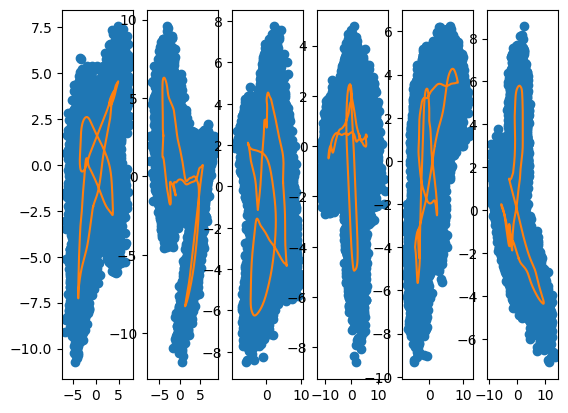

In [15]:
data_plot_density = 1
fig, axs = plt.subplots(ncols=n_projections)
for i in range(n_projections):
    axs[i].scatter(projected_data[::data_plot_density, i, 0], projected_data[::data_plot_density, i, 1], color="C0")
    axs[i].plot(projected_test_embedding[:, i, 0], projected_test_embedding[:, i, 1], color="C1")


In [16]:
with torch.no_grad():
    decoded_points, decoded_angles = decoder(torch.tensor(normed_rates, dtype=torch.get_default_dtype()).to(device))

predicted_phases = torch.squeeze(decoded_angles).cpu().numpy()


In [17]:
def reference_phases(phases):
    phases_refd = phases - phases[0]
    phases_refd = np.arctan2(np.sin(phases_refd), np.cos(phases_refd))
    return phases_refd * np.sign(phases_refd[1])

def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_ax):
    refd_test_phases = reference_phases(predicted_phases)
    refd_true_phases = reference_phases(ground_truth_phases)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_ax.scatter(refd_true_phases, refd_test_phases)
    plot_ax.plot(line, line, color="black", linestyle="--", label="y=x")
    plot_ax.set_xlabel("True Phase")
    plot_ax.set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases


In [18]:
not_nan_angle_idx = np.argwhere(np.logical_not(np.isnan(angles)))
not_nan_angles = angles[not_nan_angle_idx]
not_nan_preds = predicted_phases[not_nan_angle_idx]

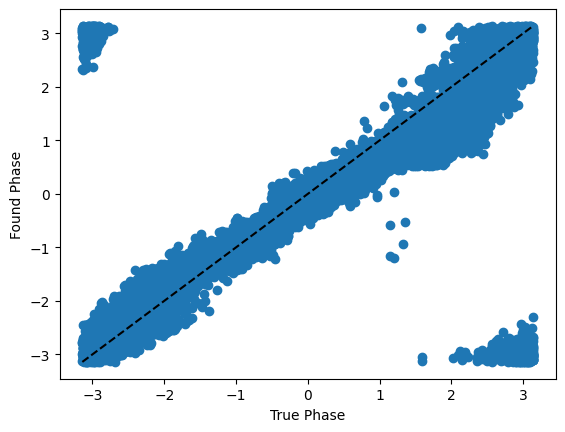

In [19]:
fig, axs = plt.subplots()
refd_pred, refd_data = compare_to_ground_truth(not_nan_preds, not_nan_angles, axs)
